In [ ]:
import scienceplots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import seaborn as sns

plt.style.use(['science', 'grid', 'bright'])

# path games of jupyter
import os
os.environ['PATH'] = "/Library/TeX/texbin:" + os.environ['PATH']

from cmcrameri import cm

# incorporate base directory for src files
import sys
sys.path.append(os.path.join(os.getcwd(), "..")) 
from src.utils import votable_to_pandas
from src.data import get_data_basic_matches

In [3]:
# ratios for figures

pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.
width = 242.26653 
twoc = 513.11743
jour_sizes = {"apj": {"onecol": width*pt, "twocol": twoc*pt}}

my_width = jour_sizes["apj"]["onecol"]
twocol = jour_sizes["apj"]["twocol"]
# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2

In [4]:
# set sizes for subplots
# from jwalton https://jwalton.info/Embed-Publication-Matplotlib-Latex/

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [5]:
# read data

df_all_model = pd.read_parquet('../scripts/nway_csc21_gaia3_full_neg_study_dis_niter200.parquet')

In [85]:
df_all_model.columns

Index(['csc21_name', 'csc21_ra', 'csc21_dec', 'csc21_errmaj', 'csc21_errmin',
       'csc21_errpa', 'hard_hs', 'hard_hm', 'hard_hm_lolim', 'hard_hm_hilim',
       'hard_ms', 'hard_ms_lolim', 'hard_ms_hilim', 'var_intra_prob_b',
       'var_intra_index_b', 'var_inter_prob_b', 'var_inter_index_b',
       'var_inter_sigma_b', 'extent_flag', 'pileup_flag', 'var_flag',
       'src_area_b', 'photflux_aper_b', 'photflux_aper_hilim_b',
       'photflux_aper_lolim_b', 'acis_time', 'min_theta_mean',
       'yangetal_gcs_class', 'yangetal_training_class', 'perezdiazetal_class',
       'gaia3_source_id', 'gaia3_ra', 'gaia3_dec', 'gaia3_era', 'gaia3_edec',
       'gaia3_epa', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
       'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_error',
       'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
  

In [89]:
# create a census description of the df_all_model
# 1. how many Gaia candidates per CSC source?
candidates_per_src = df_all_model.groupby('csc21_name').size()

# ----- overall statistics -----
stats = pd.DataFrame(
    {
        "Metric": [
            "Total CSC sources",
            "Total Gaia candidate counterparts",
            "Mean candidates per CSC source",
            "Median candidates per CSC source",
            "Maximum candidates for a single CSC source",
        ],
        "Value": [
            candidates_per_src.size,
            len(df_all_model),
            f"{candidates_per_src.mean():.2f}",
            candidates_per_src.median(),
            candidates_per_src.max(),
        ],
    }
)

# ------------------------------------------------------------------
# 2. slice statistics: how many CSC sources fall in each candidate‑count bin?
slice_counts = {
    "Exactly 1 candidate":            (candidates_per_src == 1).sum(),
    "≤ 5 candidates (total ≤5)":      (candidates_per_src <= 5).sum(),
    "5 – 10 candidates":              ((candidates_per_src > 5)  & (candidates_per_src <= 10)).sum(),
    "10 – 20 candidates":             ((candidates_per_src > 10) & (candidates_per_src <= 20)).sum(),
    "> 20 candidates":                (candidates_per_src > 20).sum(),
}

slice_stats = (
    pd.Series(slice_counts, name="Number of CSC sources")
      .to_frame()
      .rename_axis("Candidate‑count bin")
)



In [91]:
stats

,Metric,Value
0,Total CSC sources,254309
1,Total Gaia candidate counterparts,2402340
2,Mean candidates per CSC source,9.45
3,Median candidates per CSC source,3.0
4,Maximum candidates for a single CSC source,297


In [90]:
slice_stats

,Number of CSC sources
Candidate‑count bin,
Exactly 1 candidate,88040
≤ 5 candidates (total ≤5),165032
5 – 10 candidates,31441
10 – 20 candidates,26466
> 20 candidates,31370


In [151]:
# ...existing code...

# Subsets
subset_pany = df_all_model[df_all_model['p_any'] >= 0.5].copy()
subset_match1 = df_all_model[df_all_model['match_flag'] == 1].copy()
subset_match2 = df_all_model[df_all_model['match_flag'] == 2].copy()

# Group by CSC source to get counts
csc_sources_pany = subset_pany.groupby('csc21_name').size()
csc_sources_match1 = subset_match1.groupby('csc21_name').size()
csc_sources_match2 = subset_match2.groupby('csc21_name').size()

def make_stats_and_slices(counts_series):
    # Same stats structure
    stats_df = pd.DataFrame({
        "Metric": [
            "Total CSC sources",
            "Total Gaia candidates",
            "Mean candidates per CSC",
            "Median candidates per CSC",
            "Max candidates"
        ],
        "Value": [
            counts_series.size,
            counts_series.sum(),
            f"{counts_series.mean():.2f}",
            counts_series.median(),
            counts_series.max()
        ],
    })
    
    slice_counts = {
        "Exactly 1 candidate":   (counts_series == 1).sum(),
        "≤ 5 candidates":        (counts_series <= 5).sum(),
        "5 – 10 candidates":     ((counts_series > 5) & (counts_series <= 10)).sum(),
        "10 – 20 candidates":    ((counts_series > 10) & (counts_series <= 20)).sum(),
        "> 20 candidates":       (counts_series > 20).sum(),
    }
    slice_stats = (
        pd.Series(slice_counts, name="Number of CSC sources")
          .to_frame()
          .rename_axis("Candidate-count bin")
    )
    return stats_df, slice_stats

stats_pany, slice_pany = make_stats_and_slices(csc_sources_pany)
stats_match1, slice_match1 = make_stats_and_slices(csc_sources_match1)
stats_match2, slice_match2 = make_stats_and_slices(csc_sources_match2)

display(stats_pany)
display(slice_pany)
display(stats_match1)
display(slice_match1)
display(stats_match2)
display(slice_match2)
# ...existing code...

,Metric,Value
0,Total CSC sources,122192
1,Total Gaia candidates,1169082
2,Mean candidates per CSC,9.57
3,Median candidates per CSC,3.0
4,Max candidates,288


,Number of CSC sources
Candidate-count bin,
Exactly 1 candidate,38918
≤ 5 candidates,75917
5 – 10 candidates,15962
10 – 20 candidates,15004
> 20 candidates,15309


,Metric,Value
0,Total CSC sources,254309
1,Total Gaia candidates,254309
2,Mean candidates per CSC,1.00
3,Median candidates per CSC,1.0
4,Max candidates,1


,Number of CSC sources
Candidate-count bin,
Exactly 1 candidate,254309
≤ 5 candidates,254309
5 – 10 candidates,0
10 – 20 candidates,0
> 20 candidates,0


,Metric,Value
0,Total CSC sources,14379
1,Total Gaia candidates,29616
2,Mean candidates per CSC,2.06
3,Median candidates per CSC,1.0
4,Max candidates,76


,Number of CSC sources
Candidate-count bin,
Exactly 1 candidate,9844
≤ 5 candidates,13526
5 – 10 candidates,553
10 – 20 candidates,219
> 20 candidates,81


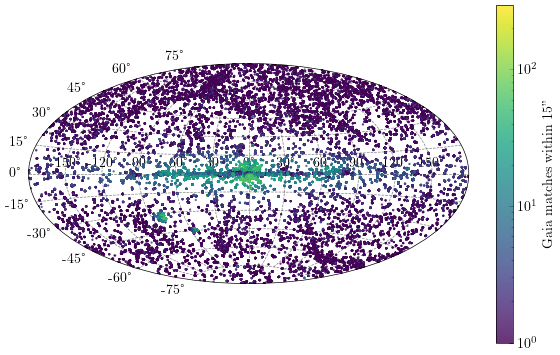

In [ ]:
# Scatter plot: all Chandra sources, colored by number of possible optical matches

# drop duplicates
unique_df = df_all_model.drop_duplicates(subset='csc21_name')

# get galactic coords
coords = SkyCoord(ra=unique_df['csc21_ra'], dec=unique_df['csc21_dec'], unit='degree')
gal = coords.galactic

# convert to radians, wrapping l at 180 deg so that it goes [-pi, +pi]
l = gal.l.wrap_at(180 * u.deg).radian
b = gal.b.radian

# "count" is the number of optical sources within 15"
count_vals = unique_df['count'].values

fig = plt.figure(figsize=(twocol, twocol/golden))
ax = plt.subplot(111, projection='aitoff')

# scatter: color = count
sc = ax.scatter(l, b, c=count_vals, s=0.4,
                cmap='viridis', norm=LogNorm(),
                alpha=0.8)

# colorbar
cb = fig.colorbar(sc, ax=ax)
cb.set_label('Gaia matches within $15"$')

plt.savefig('figures/chandra_optical_sky.pdf', bbox_inches='tight')
plt.show()

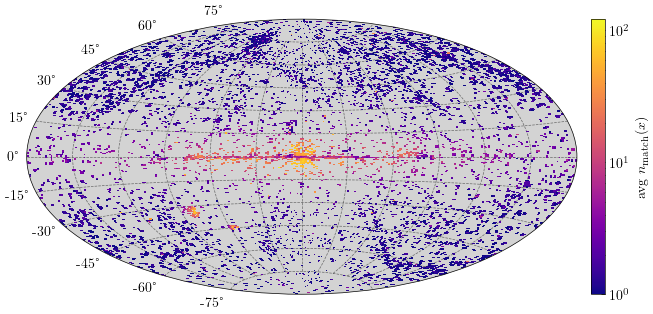

In [34]:
# Heatmap: average number of possible optical matches per X-ray source per bin

# drop duplicates
unique_df = df_all_model.drop_duplicates(subset='csc21_name')

# get galactic coords
coords = SkyCoord(ra=unique_df['csc21_ra'], dec=unique_df['csc21_dec'], unit='degree')
gal = coords.galactic

# convert to radians, wrapping l at 180 deg so that it goes [-pi, +pi]
l = gal.l.wrap_at(180 * u.deg).radian
b = gal.b.radian

# "count" is the number of optical sources within 15"
count_vals = unique_df['count'].values

# histogram in 2D, building the sum of 'count' per bin and the number of points per bin
bins = 300
H_sum, xedges, yedges = np.histogram2d(l, b, bins=bins, weights=count_vals)
H_num, _, _ = np.histogram2d(l, b, bins=[xedges, yedges])  # same edges

# average crowding, ignoring bins that have zero data
with np.errstate(invalid='ignore'):
    avg_crowding = H_sum / H_num  # array with shape (bins, bins)

# define bin centers for pcolormesh
xcenter = 0.5*(xedges[:-1] + xedges[1:])
ycenter = 0.5*(yedges[:-1] + yedges[1:])

# mask or set to NaN the bins with no coverage
avg_crowding[H_num < 1] = np.nan  # so those cells appear blank or a special color

fig = plt.figure(figsize=(twocol, twocol/golden))
ax = plt.subplot(111, projection='aitoff')
ax.set_facecolor('lightgray')  # so "no coverage" stands out if we set nan color to white

# pcolormesh with log color scale
pc = ax.pcolormesh(xcenter, ycenter, avg_crowding.T,  # note .T because histogram2d outputs [x,y]
                   cmap='plasma', norm=LogNorm(), shading='auto')

# delete labels from inside
ax.set_xticklabels([])
ax.set_axisbelow(True)

# colorbar whose height (or width) in sync with the master axes¶
pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.02, pos.y0, 0.02, pos.height])
cbar = fig.colorbar(pc, cax=cax)
cbar.set_label("avg $n_{\\mathrm{match}}(x)$")

plt.savefig('figures/chandra_optical_sky_hist.pdf', bbox_inches='tight')
plt.show()


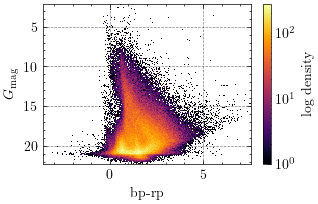

In [11]:
#bp-rp vs gmag for all sources with match_flag == 1
df_matches_nway = df_all_model[df_all_model['match_flag'] == 1]

# remove rows with NaN values in 'bp_rp' or 'phot_g_mean_mag'
df_matches_nway_clean = df_matches_nway.dropna(subset=['bp_rp', 'phot_g_mean_mag'])

fig, ax = plt.subplots(figsize=(my_width, my_width/golden))

# 2D histogram with logarithmic color scale
hist = ax.hist2d(df_matches_nway_clean['bp_rp'], df_matches_nway_clean['phot_g_mean_mag'], bins=200, cmap='inferno', norm=LogNorm())

# color bar
cb = fig.colorbar(hist[3], ax=ax)
cb.set_label('log density')

ax.set_xlabel('bp-rp')
# latex 'G_{\text{mag}}'
ax.set_ylabel(r'$G_{\mathrm{mag}}$')
ax.invert_yaxis()  # invert y-axis to match the typical astronomical convention
plt.savefig('figures/bp_rp_vs_gmag_density_hist.pdf', bbox_inches='tight')
plt.show()

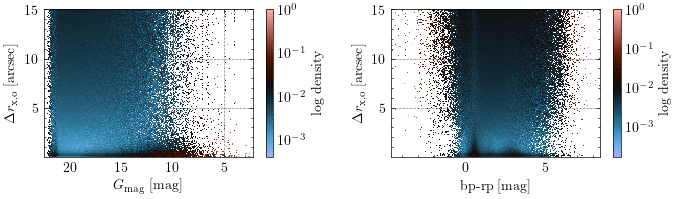

In [149]:
# 1x2 subplots comparing 'separation' vs phot_g_mean_mag and bp_rp, vertically normalized

fig, axes = plt.subplots(1, 2, figsize=set_size(twoc, fraction=1.0, subplots=(1, 2)))

# 1) separation vs phot_g_mean_mag
ax = axes[0]
df_g_clean = df_all_model.dropna(subset=['phot_g_mean_mag', 'separation'])
x_g = df_g_clean['phot_g_mean_mag'].values
y_sep = df_g_clean['separation'].values

H_g, xedges_g, yedges_g = np.histogram2d(x_g, y_sep, bins=200)
# normalize each row
H_g_sums = H_g.sum(axis=1)
H_g_sums[H_g_sums == 0] = 1  # avoid division by zero
H_g /= H_g_sums[:, np.newaxis]

im_g = axes[0].pcolormesh(xedges_g, yedges_g, H_g.T, cmap=cm.berlin, norm=LogNorm(), shading='auto')
cb_g = fig.colorbar(im_g, ax=axes[0])
cb_g.set_label('log density')
ax.set_xlabel(r'$G_{\mathrm{mag}}$ [mag]')
ax.set_ylabel(r'$\Delta r_{\mathrm{x, o}}$ [arcsec]')
ax.invert_xaxis()  # invert x-axis to match astronomical convention

# 2) separation vs bp_rp
ax = axes[1]
df_bprp_clean = df_all_model.dropna(subset=['bp_rp', 'separation'])
x_bprp = df_bprp_clean['bp_rp'].values
y_sep = df_bprp_clean['separation'].values

H_bprp, xedges_bprp, yedges_bprp = np.histogram2d(x_bprp, y_sep, bins=200)
# normalize each row
H_bprp_sums = H_bprp.sum(axis=1)
H_bprp_sums[H_bprp_sums == 0] = 1  # avoid division by zero
H_bprp /= H_bprp_sums[:, np.newaxis]

mesh_bprp = ax.pcolormesh(xedges_bprp, yedges_bprp, H_bprp.T, cmap=cm.berlin, norm=LogNorm(), shading='auto')
cb_bprp = fig.colorbar(mesh_bprp, ax=ax)
cb_bprp.set_label('log density')
ax.set_xlabel('bp-rp [mag]')
ax.set_ylabel(r'$\Delta r_{\mathrm{x, o}}$ [arcsec]')

plt.tight_layout()
plt.savefig('figures/separation_vs_params_density_hist_gaia.pdf', bbox_inches='tight')
plt.show()

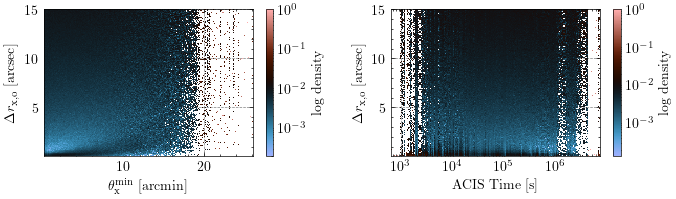

In [ ]:
# 1x2 subplots comparing 'separation' vs columns:
# min_theta_mean, acis_time

fig, axes = plt.subplots(1, 2, figsize=set_size(twoc, fraction=1.0, subplots=(1, 2)))

# 3) separation vs min_theta_mean
ax = axes[0]
df_theta_clean = df_all_model.dropna(subset=['min_theta_mean', 'separation'])

# Compute 2D histogram manually
counts_theta, xedges_theta, yedges_theta = np.histogram2d(
    df_theta_clean['min_theta_mean'],
    df_theta_clean['separation'],
    bins=200
)

# normalize each row
col_sums_theta = counts_theta.sum(axis=1)
col_sums_theta[col_sums_theta == 0] = 1  # avoid division by zero
counts_theta /= col_sums_theta[:, np.newaxis]


im_theta = axes[0].pcolormesh(xedges_theta, yedges_theta, counts_theta.T, cmap=cm.berlin, norm=LogNorm(), shading='auto')
cb_theta = fig.colorbar(im_theta, ax=axes[0])
cb_theta.set_label('log density')
axes[0].set_xlabel(r'$\theta^{\mathrm{min}}_{\mathrm{x}}$ [arcmin]')
axes[0].set_ylabel(r'$\Delta r_{\mathrm{x, o}}$ [arcsec]')

# 4) separation vs acis_time
ax = axes[1]
df_acis_clean = df_all_model.dropna(subset=['acis_time', 'separation'])
xmin, xmax = df_acis_clean['acis_time'].min(), df_acis_clean['acis_time'].max()
# make logarithmically spaced bins for the x-axis
xbins = np.logspace(np.log10(xmin), np.log10(xmax), 200)
# Compute and normalize the second histogram
counts_acis, xedges_acis, yedges_acis = np.histogram2d(
    df_acis_clean['acis_time'],
    df_acis_clean['separation'],
    bins=[xbins, 200]
)

# normalize each row
col_sums_acis = counts_acis.sum(axis=1)
col_sums_acis[col_sums_acis == 0] = 1  # avoid division by zero
counts_acis /= col_sums_acis[:, np.newaxis]

im_acis = axes[1].pcolormesh(xedges_acis, yedges_acis, counts_acis.T, cmap=cm.berlin, norm=LogNorm(), shading='auto')
cb_acis = fig.colorbar(im_acis, ax=axes[1])
cb_acis.set_label('log density')
axes[1].set_xlabel('ACIS Time [s]')
axes[1].set_ylabel(r'$\Delta r_{\mathrm{x, o}}$ [arcsec]')
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig('figures/separation_vs_params_density_hist_chandra.pdf', bbox_inches='tight')
plt.show()

#### The Positive and Negative set

In [ ]:
df_pos_gen, df_neg_gen = get_data_basic_matches(df_all_model, '0-3', 1.3)

Range 0-3: 30279 positives, 310020 negatives


In [ ]:
datasets = {
    "pos": df_pos_gen,
    "intermediate": df_neg_gen[df_neg_gen['negative_type'] == 'intermediate'],
    "clear_negative": df_neg_gen[df_neg_gen['negative_type'] == 'clear_negative'],
}

/Users/vp2435/miniconda3/envs/chandragaia/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/vp2435/miniconda3/envs/chandragaia/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/vp2435/miniconda3/envs/chandragaia/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


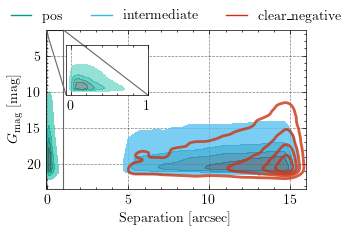

In [148]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# ------------------------------------------------------------------
# make the main figure
fig, ax = plt.subplots(figsize=(my_width, my_width / golden))

colors = ["#009988", "#33BBEE",  "#CC3311"]

for i, (name, data) in enumerate(datasets.items()):
    filtered = data.dropna(subset=['photflux_aper_b', 'separation'])

    x = filtered['separation'].values          # keep linear units!
    y = filtered['phot_g_mean_mag'].values

    # sample large sets for speed
    if len(x) > 200000:
        idx = np.random.choice(len(x), 200000, replace=False)
        x, y = x[idx], y[idx]

    # KDE for all three groups on the main axes
    sns.kdeplot(
        x=x, y=y,
        fill=(name != 'clear_negative'),
        levels=5,
        ax=ax,
        bw_adjust=0.8,
        linewidths=2,
        alpha=0.8,
        color=colors[i],
    )

    # manual legend handle
    ax.plot([], [], color=colors[i], label=name)

# ----- axis styling ------------------------------------------------
#ax.set_xscale('symlog', linthresh=2, base=10)     # linear core  (|x|<2")
ax.set_xlabel('Separation [arcsec]')
ax.set_ylabel(r'$G_{\mathrm{mag}}$ [mag]')
ax.invert_yaxis()

ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, 1.2), ncol=3,
          handlelength=1.5, frameon=False)

# ------------------------------------------------------------------
# inset that zooms on the 0‑2″ region for the 'pos' objects
# ------------------------------------------------------------------
axins = inset_axes(ax, width="35%", height="35%", loc='upper left',
                   bbox_to_anchor=(0.05, 0.05, 0.9, 0.9),
                   bbox_transform=ax.transAxes)

# only the positive class; scatter is clearer here
pos = datasets['pos'].dropna(subset=['photflux_aper_b', 'separation'])
sns.kdeplot(
    x=pos['separation'], 
    y=pos['phot_g_mean_mag'], 
    ax=axins, 
    fill=True, 
    levels=5, 
    bw_adjust=0.8, 
    linewidths=2, 
    alpha=0.6, 
    color=colors[0]
)
axins.set_xlabel('')
axins.set_ylabel('')
axins.set_xlim(ax.get_xlim()[0], 1)
axins.set_ylim(ax.get_ylim())        # same magnitude range
axins.set_xticks([0, 1])  # ticks for inset
axins.set_yticks([])                 # keep it clean

# little grey frame around the zoomed region
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.4", lw=0.8)

# ------------------------------------------------------------------
plt.savefig('figures/kde_gmag_vs_separation_negative_types.pdf',
            bbox_inches='tight')
plt.show()


### Plots with train, val, test data

In [ ]:
# whole csc
from astropy.io.votable import parse_single_table
from astropy.table import Table

# Load the VOTable
votable_path = '../data/csc211_epos.vot'
csc211_epos = votable_to_pandas(votable_path)

In [44]:
from src.data import get_data_basic_matches
from sklearn.model_selection import train_test_split
from src.utils import transform_features, normalize_train_test
import seaborn as sns 

In [8]:
from joblib import load

benchmark_ids = load('../scripts/jobs/models/neg_study_dis_niter200_withint_with_int_5X_lgbm_0-3_20241113_235113/benchmark_ids.joblib')

def get_train_val_test_splits(df_all_model, benchmark_ids, range_offaxis='0-3', separation=1.3):
   # get initial positives and split test set
   df_pos, _ = get_data_basic_matches(df_all_model, range_offaxis, separation)
   cscids = df_pos['csc21_name'].unique()
   cscids_train_val, cscids_test = train_test_split(cscids, test_size=0.2, random_state=42)
   
   # get train/val split from filtered train_val data
   df_train_val = df_all_model[df_all_model['csc21_name'].isin(cscids_train_val)]
   train_pos, _ = get_data_basic_matches(df_train_val, range_offaxis, separation)
   train_val_cscids = train_pos['csc21_name'].unique()
   cscids_train, cscids_val = train_test_split(train_val_cscids, test_size=0.2, random_state=42)
   
   assert set(benchmark_ids) == set(cscids_test)
   
   # get final datasets
   splits = {}
   for name, ids in [('train', cscids_train), ('val', cscids_val), ('test', cscids_test)]:
       data = df_all_model[df_all_model['csc21_name'].isin(ids)]
       pos, neg = get_data_basic_matches(data, range_offaxis, separation)
       splits[name] = {'pos': pos, 'neg': neg, 'full': data}
       
   return splits

splits = get_train_val_test_splits(df_all_model, benchmark_ids)

def validate_splits(splits, model_path):
   """validate train/val splits match saved model data"""
   
   # combine pos/neg sets
   val_data = splits['val']['full']
   train_data = splits['train']['full']
   
   # load saved validation data
   X_eval_saved = load(os.path.join(model_path, 'X_eval.joblib'))
   y_eval_saved = load(os.path.join(model_path, 'y_eval.joblib'))
   
   # prepare validation data
   val_data = val_data.copy()
   val_data['eval_label'] = np.where(val_data['match_flag'] == 1, 1, 0)
   
   # preprocess
   X_train, _ = transform_features(train_data, log_transform=False, model_type='lgbm')
   X_val, cat_features = transform_features(val_data, log_transform=False, model_type='lgbm')
   _, X_val_norm, _ = normalize_train_test(X_train, X_val, method='none', 
                                         categorical_features=cat_features)
   
   # verify
   assert X_eval_saved.equals(X_val_norm)
   assert np.array_equal(y_eval_saved, val_data['eval_label'].values)
   
   return True

validate_splits(splits, '../scripts/jobs/models/neg_study_dis_niter200_withint_with_int_5X_lgbm_0-3_20241113_235113')

Range 0-3: 30279 positives, 310020 negatives
Range 0-3: 24223 positives, 245627 negatives
Range 0-3: 19378 positives, 195135 negatives
Range 0-3: 4845 positives, 50492 negatives
Range 0-3: 6056 positives, 64393 negatives


True

In [12]:
# get the test data + everything from the dataset that was not in train and val
test_data = splits['test']['full']

# now get everything that was not in train and val
train_val_data = pd.concat([splits['train']['full'], splits['val']['full']])
train_val_ids = train_val_data['csc21_name'].unique()
not_train_val_data = df_all_model[~df_all_model['csc21_name'].isin(train_val_ids)].copy()

# check if test is IN not_train_val_data
assert set(test_data['csc21_name'].unique()) <= set(not_train_val_data['csc21_name'].unique())

In [17]:
# Ensure 'separation' column exists in all relevant tables

# CSC-NWAY
df_nway_unique = df_all_model.copy()
df_nway_unique['separation'] = df_all_model['separation']  # Ensure 'separation' column is present
df_nway_unique_filtered = df_nway_unique.dropna(subset=['photflux_aper_b'])

# Training
train_val_data['separation'] = train_val_data['separation']  # Ensure 'separation' column is present

# Application
not_train_val_data['separation'] = not_train_val_data['separation']  # Ensure 'separation' column is present

# Test
test_data['separation'] = test_data['separation']  # Ensure 'separation' column is present


/var/folders/2j/bgzn208n7s93xhqxhxjy85nh0000gp/T/ipykernel_2664/3773417123.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['separation'] = test_data['separation']  # Ensure 'separation' column is present


/Users/vp2435/miniconda3/envs/chandragaia/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/vp2435/miniconda3/envs/chandragaia/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


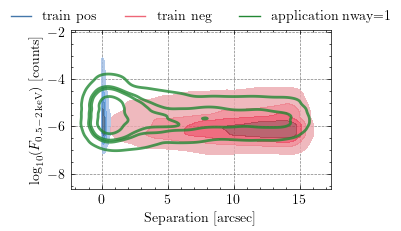

In [ ]:
# Ensure 'photflux_aper_b' and 'separation' columns are present and drop NaN values

datasets = {
    "train pos": train_val_data[train_val_data['match_flag'] == 1],
    #"test pos": test_data,
    "train neg": train_val_data[train_val_data['match_flag'] != 1],
    "application nway=1": not_train_val_data[not_train_val_data['match_flag'] == 1],
   # "nway": df_nway_unique_filtered
}

fig, ax = plt.subplots(figsize=(my_width, my_width/golden))

colors = sns.color_palette(n_colors=len(datasets))  # assign distinct colors

for i, (name, data) in enumerate(datasets.items()):
    filtered = data.dropna(subset=['photflux_aper_b', 'separation'])
    #filtered = filtered[filtered['match_flag'] == 1]
    filtered = filtered[filtered['photflux_aper_b'] > 0]

    x = filtered['separation'].values
    y = np.log10(filtered['photflux_aper_b'].values)

    if len(x) > 10_000:
        idx = np.random.choice(len(x), 10000, replace=False)
        x, y = x[idx], y[idx]

    if name == 'application nway=1':
        # apply a mask to the data
        fill_cont = False
    else: fill_cont = True;
    sns.kdeplot(
        x=x, y=y,
        fill=fill_cont,
        levels=5,
        ax=ax,
        bw_adjust=0.8,
        linewidths=2,
        alpha=0.8,
        color=colors[i]
    )

    # manually plant a legend label
    ax.plot([], [], color=colors[i], label=name)

ax.set_xlabel('Separation [arcsec]')
ax.set_ylabel(r'$\log_{10}(F_{0.5-2\,\mathrm{keV}})$ [counts]')

# put legend outside of frame, center, top
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3,
            handlelength=1.5, handleheight=0.5, frameon=False)


plt.savefig('figures/sns_kde_photflux_vs_separation.pdf', bbox_inches='tight')
plt.show()



In [66]:
df_all_model.columns

Index(['csc21_name', 'csc21_ra', 'csc21_dec', 'csc21_errmaj', 'csc21_errmin',
       'csc21_errpa', 'hard_hs', 'hard_hm', 'hard_hm_lolim', 'hard_hm_hilim',
       'hard_ms', 'hard_ms_lolim', 'hard_ms_hilim', 'var_intra_prob_b',
       'var_intra_index_b', 'var_inter_prob_b', 'var_inter_index_b',
       'var_inter_sigma_b', 'extent_flag', 'pileup_flag', 'var_flag',
       'src_area_b', 'photflux_aper_b', 'photflux_aper_hilim_b',
       'photflux_aper_lolim_b', 'acis_time', 'min_theta_mean',
       'yangetal_gcs_class', 'yangetal_training_class', 'perezdiazetal_class',
       'gaia3_source_id', 'gaia3_ra', 'gaia3_dec', 'gaia3_era', 'gaia3_edec',
       'gaia3_epa', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
       'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_error',
       'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
  

/Users/vp2435/miniconda3/envs/chandragaia/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/vp2435/miniconda3/envs/chandragaia/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


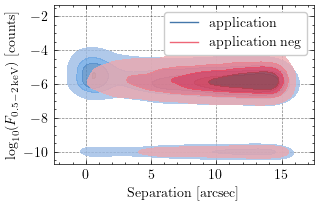

In [65]:
# Ensure 'photflux_aper_b' and 'separation' columns are present and drop NaN values

datasets = {
    #"train pos": train_val_data[train_val_data['match_flag'] == 1],
    "application": not_train_val_data[not_train_val_data['p_match_ind'] >= 0.35],
    "application neg": not_train_val_data[not_train_val_data['p_match_ind'] < 0.35],
    #"test pos": test_data,
   # "train neg": train_val_data[train_val_data['match_flag'] != 1],
   # "nway": df_nway_unique_filtered
}

fig, ax = plt.subplots(figsize=(my_width, my_width/golden))

colors = sns.color_palette(n_colors=len(datasets))  # assign distinct colors

for i, (name, data) in enumerate(datasets.items()):
    filtered = data.dropna(subset=['photflux_aper_b', 'separation'])
    #filtered = filtered[filtered['match_flag'] == 1]
    x = filtered['separation'].values
    y = np.log10(filtered['photflux_aper_b'].values + 1e-10)

    if len(x) > 10_000:
        idx = np.random.choice(len(x), 10000, replace=False)
        x, y = x[idx], y[idx]

    sns.kdeplot(
        x=x, y=y,
        fill=True,
        levels=5,
        ax=ax,
        bw_adjust=0.8,
        linewidths=2,
        alpha=0.8,
        color=colors[i]
    )

    # manually plant a legend label
    ax.plot([], [], color=colors[i], label=name)

ax.set_xlabel('Separation [arcsec]')
ax.set_ylabel(r'$\log_{10}(F_{0.5-2\,\mathrm{keV}})$ [counts]')
# set y axis to log, but don't modify values
#ax.set_yscale('log')
ax.legend(loc='best')

plt.savefig('figures/photflux_vs_separation_application.pdf', bbox_inches='tight')
plt.show()

